In [2]:
from astropy.io import fits
from astropy.table import Table
import numpy as np
import matplotlib.pyplot as plt
import glob
import pandas as pd
import os
import sys
sys.path.append("/Users/Trevor1/Dropbox/HST/HSTCode/")
sys.path.append("/Users/trevormccaffrey/Dropbox/HST/HSTCode/")
from Small_Pix_Filter_TVM import SDSS_pixel_filter

In [3]:
z = 4.628
def arg2min(arr):
	#return index of second closest point
	return np.argsort(arr)[1]

In [4]:
!ls Gemini_reduction/XDGNIRS*/PRODUCTS

Gemini_reduction/XDGNIRS_v22_fullyauto/PRODUCTS:
J1554+1937.fits           J1554+1937_data_sheet.pdf orders.pdf
J1554+1937.txt            Warnings_inputfiles.txt

Gemini_reduction/XDGNIRS_v22_nrao_flskyNO/PRODUCTS:
Checks_and_Warnings.txt   J1554+1937.txt            XDGNIRS_Log.txt
J1554+1937.fits           J1554+1937_data_sheet.pdf orders.pdf

Gemini_reduction/XDGNIRS_v22_nrao_flskyYES/PRODUCTS:
Checks_and_Warnings.txt   J1554+1937.txt            XDGNIRS_Log.txt
J1554+1937.fits           J1554+1937_data_sheet.pdf orders.pdf

Gemini_reduction/XDGNIRS_v22_reduction/PRODUCTS:
J1554+1937.fits           J1554+1937_data_sheet.pdf orders.pdf
J1554+1937.txt            Warnings_inputfiles.txt


In [5]:
spec = fits.open("Gemini_reduction/XDGNIRS_v22_fullyauto/PRODUCTS/J1554+1937.fits")

In [6]:
spec[0].header

SIMPLE  =                    T / Fits standard                                  
BITPIX  =                  -32 / Bits per pixel                                 
NAXIS   =                    1 / Number of axes                                 
NAXIS1  =                 6953 / Axis length                                    
EXTEND  =                    F / File may contain extensions                    
ORIGIN  = 'NOAO-IRAF FITS Image Kernel July 2003' / FITS file originator        
DATE    = '2015-08-06T21:48:07' / Date FITS file was generated                  
IRAF-TLM= '2015-08-06T21:48:07' / Time of last modification                     
OBJECT  = 'J1554+1937'         / Name of the object observed                    
DROINUM =                    0 / roi number                                     
LOWROW  =                    0 / y min of region                                
LOWCOL  =                    0 / Start col of region of interest                
HIROW   =                 10

In [7]:
spec_txt = pd.read_csv("Gemini_reduction/XDGNIRS_v22_fullyauto/PRODUCTS/J1554+1937.txt", sep="\s+", names=["wave (Angstroms)","Flux"])
spec_txt

,wave (Angstroms),Flux
0,8450.584961,1.123224e-16
1,8452.990393,1.088884e-16
2,8455.395824,1.058398e-16
3,8457.801256,1.022399e-16
4,8460.206688,1.052197e-16
...,...,...
6948,25163.524757,1.617419e-17
6949,25165.930189,1.720679e-17
6950,25168.335621,1.795509e-17
6951,25170.741053,1.844207e-17


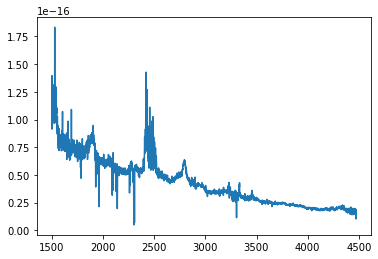

In [8]:
plt.plot(spec_txt["wave (Angstroms)"]/(1+z), spec_txt["Flux"])

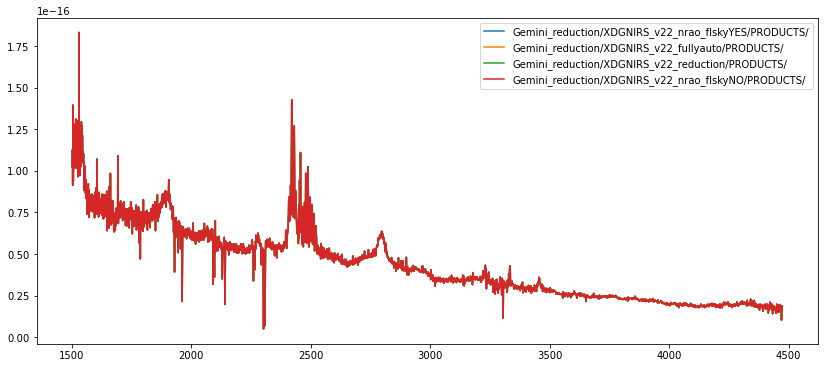

In [9]:
fig = plt.figure(figsize=(14,6))
for fold in os.listdir("Gemini_reduction/"):
    if glob.glob("Gemini_reduction/%s/PRODUCTS/"%(fold)):
        path = "Gemini_reduction/%s/PRODUCTS/"%(fold)
        spec = spec_txt = pd.read_csv("Gemini_reduction/XDGNIRS_v22_fullyauto/PRODUCTS/J1554+1937.txt", sep="\s+", names=["wave (Angstroms)","Flux"])
        wave = spec["wave (Angstroms)"].values / (1+z) ; flux = spec["Flux"].values
        plt.plot(wave, flux, label=path)
plt.legend(loc="best")
plt.show()

So each pipeline run results in the same final product... not good

There's really nothing wrong with this spectrum though, other than the obvious exposure edge blue of MgII.  But it's unlikely any code will make that data usable, so should cut that and worry more about fitting the iron templates while ignoring that bit of the spectrum.

In [10]:
wave = spec_txt["wave (Angstroms)"].values / (1+z)
flux = spec_txt["Flux"].values

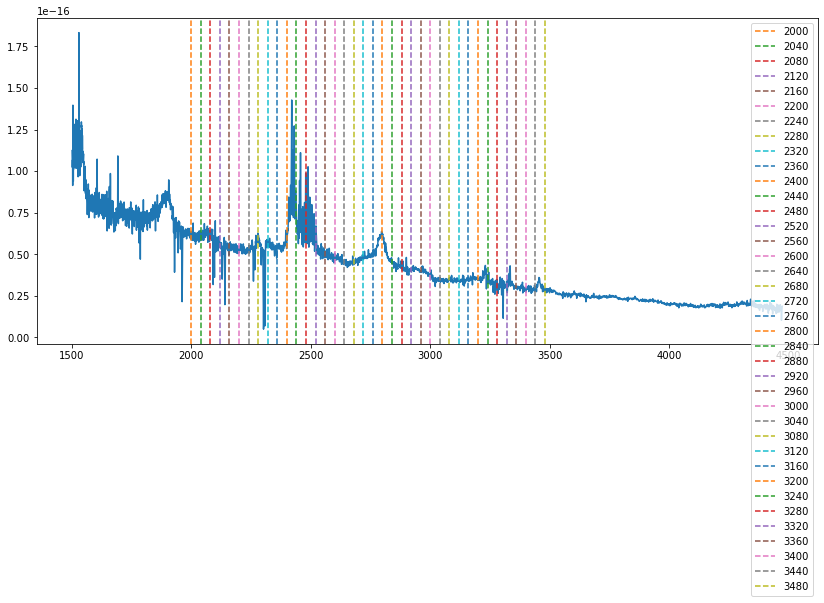

In [12]:
fig = plt.figure(figsize=(14,6))
plt.plot(wave, flux)
ylims = plt.gca().get_ylim()
for mark in np.arange(2000, 3500, 40): plt.plot([mark,mark],ylims,"--",label=mark)
plt.ylim(ylims)
plt.legend(loc="best")
plt.show()

Mask bad pixels and plot

In [13]:
badpix = ((wave>2380)&(wave<2560))|((wave>3200)&(wave<3360))
flux[badpix] = np.nan

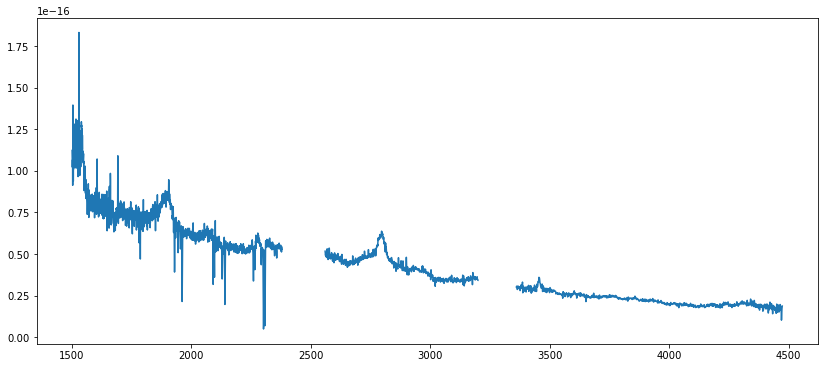

In [14]:
fig = plt.figure(figsize=(14,6))
plt.plot(wave, flux)
#plt.ylim(ylims)
#plt.legend(loc="best")
plt.show()

Now can fit this with [PyQSOFit](https://github.com/legolason/PyQSOFit).  Will need:
* To re-bin the Gemini spectrum to the SDSS wavelength scale
* An error spectrum
* Mask array?

This could should be able to fit+subtract an iron template, and give us a nice fit of the MgII line.

---

## 1) Re-bin Gemini spectrum to SDSS wavelength scale $\sim69\;{\rm km}\;{\rm s}^{-1}$

In [15]:
gem_res = [3.e5*((wave[i+1]-wave[i])/wave[i]) for i in range(len(wave)-1)]
gem_res

[85.39403227408546,
 85.36973205523762,
 85.34544566243108,
 85.32117308400548,
 85.2969143083591,
 85.27266932272383,
 85.24843811661393,
 85.22422067756035,
 85.2000169940149,
 85.17582705430655,
 85.15165084668686,
 85.12748835951136,
 85.10333958132982,
 85.07920449952817,
 85.05508310358839,
 85.03097538123978,
 85.00688132113027,
 84.98280091160406,
 84.958734140883,
 84.93468099806078,
 84.91064147021059,
 84.88661554685919,
 84.8626032164162,
 84.83860446694335,
 84.81461928705738,
 84.79064766547812,
 84.76668959080278,
 84.74274505046928,
 84.7188140343638,
 84.69489653040108,
 84.67099252718529,
 84.64710201342358,
 84.62322497756564,
 84.59936140852432,
 84.57551129410002,
 84.55167462372644,
 84.52785138572476,
 84.50404156887896,
 84.48024516171598,
 84.45646215286556,
 84.43269253164398,
 84.40893628540361,
 84.38519340398048,
 84.36146387587534,
 84.33774768969168,
 84.31404483413556,
 84.29035529823959,
 84.2666790707797,
 84.24301613951367,
 84.21936649534948,
 84.195

In [16]:
np.nanmedian(gem_res)

42.92689278813083

Wavelength resolution is not constant in log space (like SDSS), but has median resolution of 43km/s

In [18]:
#hdulist = fits.open('/Users/Trevor1/Desktop/data/spectra/VLA_8403col_1.6z2.2/lite/0266/spec-0266-51630-0080.fits')
hdulist = fits.open('/Users/trevormccaffrey/Desktop/spectra/spec-0266-51630-0080.fits')
sdss_c0 = hdulist[0].header['coeff0'] #central loglam of first pixel
sdss_c1 = hdulist[0].header['coeff1'] #loglam spacing between pixels
sdss_npix = hdulist[1].header['NAXIS2']
sdss_loglam = sdss_c0 + sdss_c1 * np.arange(sdss_npix)

#Number of SDSS pixels separating sdss_c0 and start/end of HST spectrum
npix_from_start = (min(np.log10(wave[wave!=0])) - sdss_c0) // sdss_c1
npix_from_end   = (max(np.log10(wave[wave!=0])) - sdss_c0) // sdss_c1

#Now define where starting/ending HST wave lies in SDSS
#TVM changed these lines on 09/13/21
loglam_min_rebin = sdss_c0 + npix_from_start*sdss_c1
loglam_max_rebin = sdss_c0 + npix_from_end*sdss_c1
#print(sdss_c1, np.nanmin(np.log10(wave)), npix_from_startHST, loglam_minHST_rebin, loglam_maxHST_rebin)
loglam_rebin    = np.arange(loglam_min_rebin, loglam_max_rebin+sdss_c1, sdss_c1)

#Get "edges" of new loglam pixels
loglam_rebin_edges = loglam_rebin-0.5*sdss_c1
loglam_rebin_edges = np.append(loglam_rebin_edges, loglam_rebin_edges[-1]+sdss_c1) #add final edge

#Linear HST wave on SDSS scale
wave_rebin = 10.**(loglam_rebin)
wave_rebin_edges = 10.**(loglam_rebin_edges)


#print(len(wave_HST_rebin), len(wave))

#Now want to compute HST flux at each new rebinned wave pixel - intialize first
flux_rebin    = np.zeros(len(wave_rebin))

#Get original by-pixel spacing for HST spectrum
lambdaSpacingGNIRS = np.zeros(len(wave)-1)
for i in range(len(wave)-1):
    lambdaSpacingGNIRS[i] = wave[i+1] - wave[i]

#Get the edges of pixel "bins" in HST spectrum
lambdaEdgesGNIRS = np.zeros(len(wave)+1)
lambdaEdgesGNIRS[0] = wave[0] - 0.5*lambdaSpacingGNIRS[0]
for i in range(1, len(wave)): lambdaEdgesGNIRS[i] = wave[i-1] + 0.5*lambdaSpacingGNIRS[i-1]
lambdaEdgesGNIRS[-1] = wave[-1] + 0.5*lambdaSpacingGNIRS[-1]

#######
lambdaSpacingMedianGNIRS = np.median(lambdaSpacingGNIRS)

#ABR:
#Now we'll loop through each of the pixels in the new grid and see which original pixels overlap with it
#(either completely or partially).  Then we'll compute the weighted sums of the flux densities and the
#quadrature sum of the flux density errors.
for i in range(len(wave_rebin)):
    arg1 = np.argmin(np.abs(wave-wave_rebin[i]))
    arg2 = arg2min(np.abs(wave-wave_rebin[i]))
    wave1, flux1 = wave[arg1], flux[arg1]
    wave2, flux2 = wave[arg2], flux[arg2]

    #Since there are effectively fewer photons captured in each
    #wave bin, the S/N should decrease by a factor of sqrt(old_width/new_width)
    old_width = lambdaEdgesGNIRS[arg1+1] - lambdaEdgesGNIRS[arg1] #old pixel width is that of nearest HST pixel
    new_width = wave_rebin_edges[i+1] - wave_rebin_edges[i] #new pixel width is according to the SDSS scale

    #Do linear fit on these two points
    m_flux, b_flux = np.polyfit([wave1, wave2], [flux1, flux2], 1)

    flux_rebin[i]    = m_flux*wave_rebin[i] + b_flux

In [19]:
rebin_res = [3.e5*((wave_rebin[i+1]-wave_rebin[i])/wave_rebin[i]) for i in range(len(wave_rebin)-1)]
rebin_res

[69.0855062475904,
 69.08550624758287,
 69.08550624756707,
 69.08550624756248,
 69.08550624758843,
 69.08550624757322,
 69.08550624758116,
 69.08550624754022,
 69.08550624755966,
 69.0855062476124,
 69.08550624753519,
 69.08550624757267,
 69.08550624760652,
 69.08550624756369,
 69.08550624755209,
 69.08550624758885,
 69.08550624755506,
 69.085506247558,
 69.08550624761419,
 69.08550624755894,
 69.08550624754417,
 69.08550624758578,
 69.08550624756386,
 69.08550624758435,
 69.08550624757223,
 69.08550624758782,
 69.08550624755573,
 69.08550624758104,
 69.08550624754285,
 69.08550624759094,
 69.08550624755891,
 69.08550624759611,
 69.08550624758098,
 69.08550624752709,
 69.0855062475831,
 69.08550624758179,
 69.08550624758126,
 69.08550624754922,
 69.08550624758837,
 69.08550624757592,
 69.08550624756913,
 69.08550624758,
 69.08550624757528,
 69.08550624756658,
 69.08550624756533,
 69.0855062475827,
 69.08550624753977,
 69.08550624758222,
 69.08550624758581,
 69.08550624756096,
 69.08550

In [20]:
np.nanmedian(rebin_res)

69.08550624757152

Nicely re-binned, check flux.

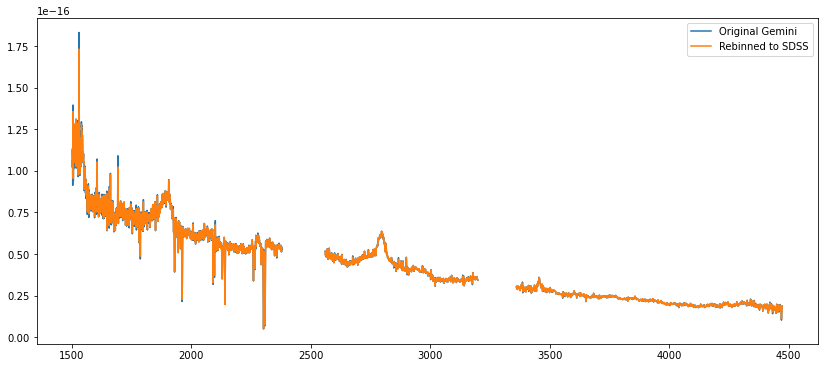

In [21]:
fig = plt.figure(figsize=(14,6))
plt.plot(wave, flux, label="Original Gemini")
plt.plot(wave_rebin, flux_rebin, label="Rebinned to SDSS")
plt.legend(loc="best")
plt.show()

Zoom in on MgII, since that's really what we care about.

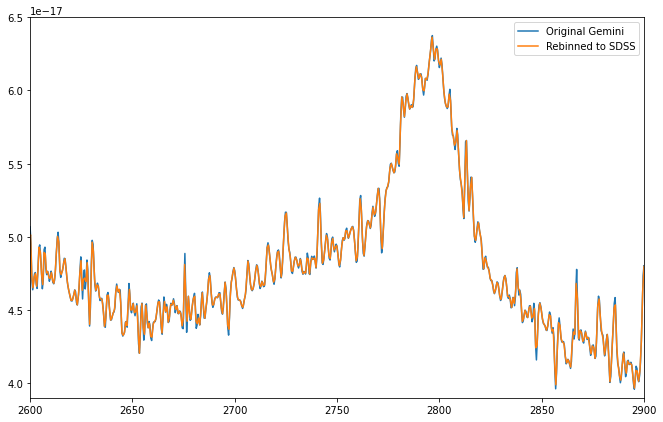

In [22]:
fig = plt.figure(figsize=(11,7))
plt.plot(wave, flux, label="Original Gemini")
plt.plot(wave_rebin, flux_rebin, label="Rebinned to SDSS")
plt.legend(loc="best")
plt.xlim(2600,2900)
plt.ylim(0.39e-16,0.65e-16)
plt.show()

---

## 2)  Now we just need an error spectrum

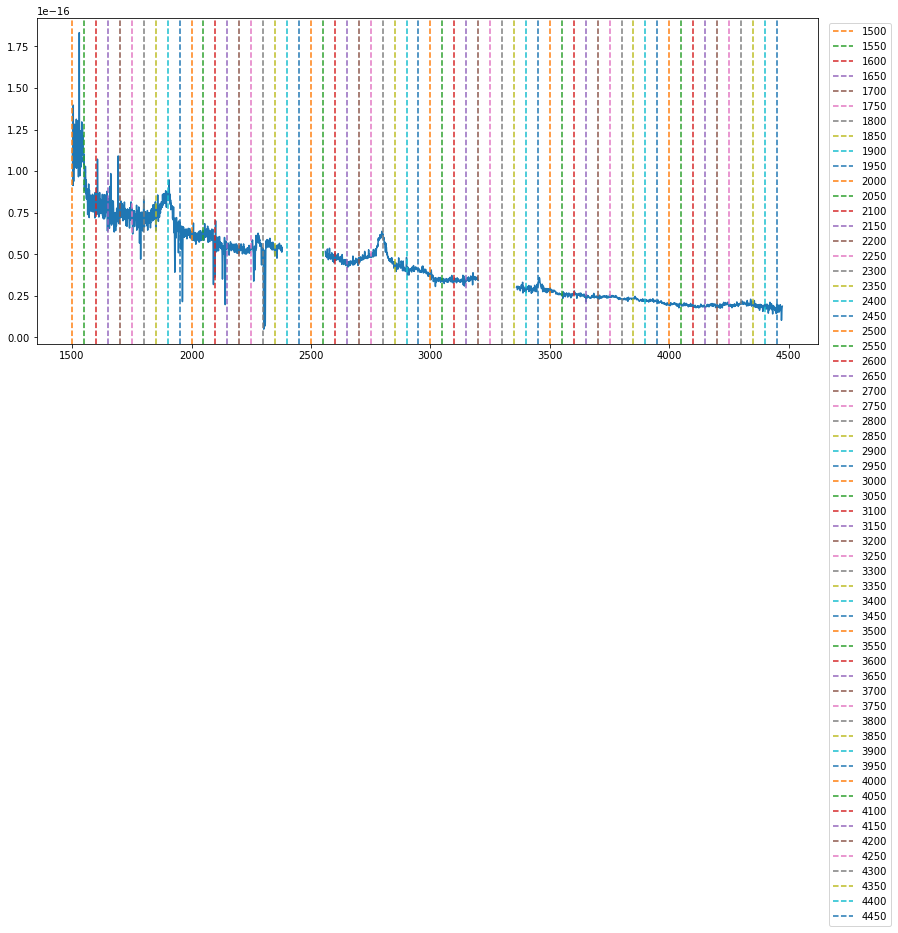

In [23]:
fig = plt.figure(figsize=(14,6))
plt.plot(wave, flux)
for mark in np.arange(1500, 4500, 50): plt.plot([mark,mark],ylims,"--",label=mark)
plt.ylim(ylims)
plt.legend(bbox_to_anchor=(1.1,1))
plt.show()

In [24]:
use_markers = np.array([1625,1750,1980,2200,2350,2600,3025,3400,3600,3800,4000,4150,4450])
cont_region = {}

for i in range(len(use_markers)-1):
    ind1 = abs(wave-use_markers[i]).argmin()
    ind2 = abs(wave-use_markers[i+1]).argmin()
    #print([wave[(ind1-5):(ind1+5)], wave[(ind2-5):(ind2+5)]],
    #                        [flux[(ind1-5):(ind1+5)], flux[(ind2-5):(ind2+5)]])
    fit_region = np.polyfit([np.nanmedian(wave[(ind1-5):(ind1+5)]), np.nanmedian(wave[(ind2-5):(ind2+5)])],
                            [np.nanmedian(flux[(ind1-5):(ind1+5)]), np.nanmedian(flux[(ind2-5):(ind2+5)])],
                             1) #do a linear fit on this section

    if len(use_markers)-2==0:
        x = wave
    elif i==0:
        x = wave[:ind2]
    elif i==(len(use_markers)-2):
        x = wave[ind1:]
    else:
        x = wave[ind1:ind2]
    y = fit_region[0]*x + fit_region[1]
    cont_region[i] = [x, y]

cont_spec = cont_region[0][1]
for i in range(1, len(use_markers)-1):
    cont_spec = np.append(cont_spec, cont_region[i][1])
    
cont_spec = SDSS_pixel_filter(wave, cont_spec, 300)

No handles with labels found to put in legend.


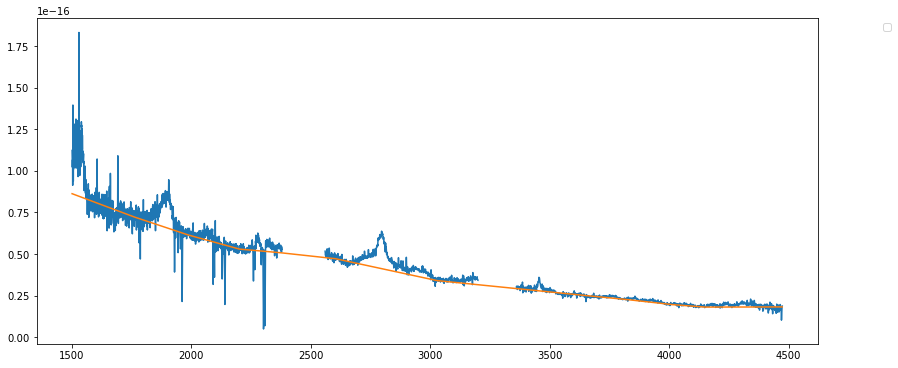

In [25]:
fig = plt.figure(figsize=(14,6))
plt.plot(wave, flux)
plt.plot(wave, cont_spec)
#for mark in np.arange(1500, 4500, 50): plt.plot([mark,mark],ylims,"--",label=mark)
plt.ylim(ylims)
plt.legend(bbox_to_anchor=(1.1,1))
plt.show()

No handles with labels found to put in legend.


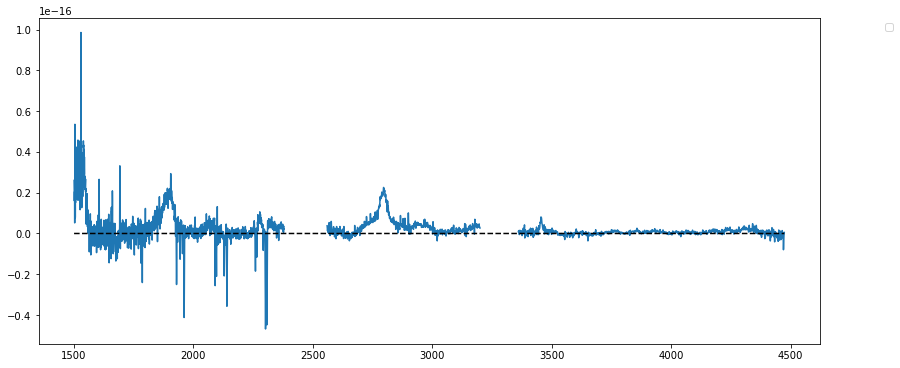

In [26]:
fig = plt.figure(figsize=(14,6))
plt.plot(wave, flux-cont_spec)
plt.plot(wave, np.zeros(len(wave)), "--k")
#plt.plot(wave, cont_spec)
#for mark in np.arange(1500, 4500, 50): plt.plot([mark,mark],ylims,"--",label=mark)
#plt.ylim(ylims)
plt.legend(bbox_to_anchor=(1.1,1))
plt.show()

(array([  2.,   1.,  18., 110., 211., 102.,  17.,   4.,   1.,   2.]),
 array([4.70110800e-17, 5.32217520e-17, 5.94324240e-17, 6.56430960e-17,
        7.18537680e-17, 7.80644400e-17, 8.42751120e-17, 9.04857840e-17,
        9.66964560e-17, 1.02907128e-16, 1.09117800e-16]),
 <BarContainer object of 10 artists>)

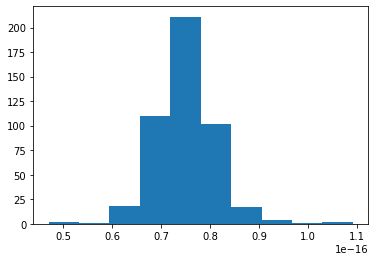

In [27]:
plt.hist(flux[(wave>1600)&(wave<1800)])

In [28]:
err = np.zeros(len(flux))

In [29]:
for i in range(len(wave)):
    flux_window = flux[max(0,i-20):min(len(wave),i+20)]-cont_spec[max(0,i-20):min(len(wave),i+20)]
    err[i] = np.std(flux_window)

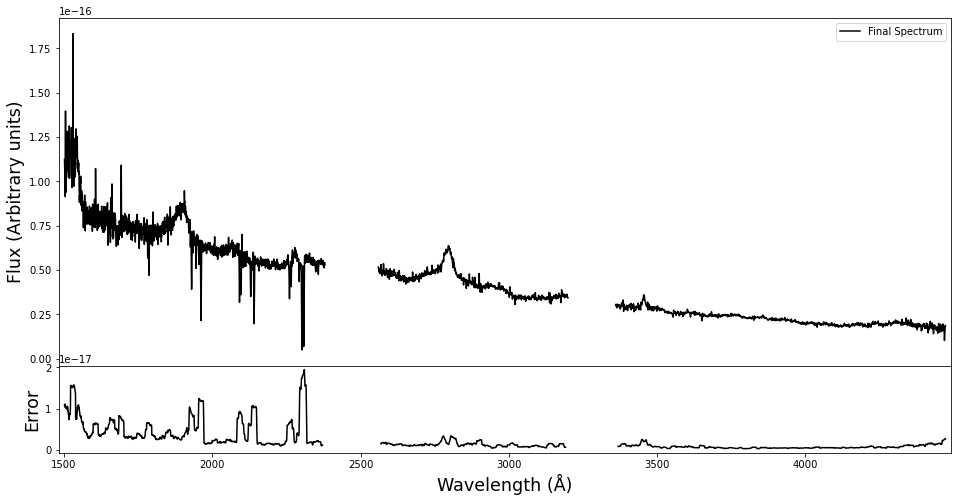

In [31]:
fig, [ax1,ax2] = plt.subplots(2, 1, figsize=(16,8), sharex=True, gridspec_kw={'height_ratios': [4, 1]})

fig.subplots_adjust(hspace=0)
ax1.plot(wave, flux, color="k", label="Final Spectrum", zorder=1)
#ax1.scatter(wave[mask==1], flux[mask==1], color="r", alpha=0.3, label="Masked Pixels - Coadd", zorder=2)
ax2.plot(wave, err, color="k", label="Final Errors", zorder=1)

ax1.set_xlim(min(wave)-20, max(wave)+20)
#ax1.set_xlim(min(wave)-2, red_expxlim)
ax2.set_xlabel("Wavelength (Å)", fontsize=17.5)
ax1.set_ylabel("Flux (Arbitrary units)", fontsize=17.5)
ax2.set_ylabel("Error", fontsize=17.5)
ax1.legend(loc=1)
plt.show()

In [32]:
mask = np.zeros(len(flux))
mask[np.isnan(err)] = 1

In [33]:
np.isnan(err[mask==0]).any(), np.isnan(flux[mask==0]).any()

(False, False)

In [34]:
t = Table([wave,flux,err,mask,z*np.ones(len(wave))],names=('Rest-frame Wavelength','Flux','Flux Errors','Mask','Redshift'))

In [36]:
#t.write("/Users/Trevor1/Dropbox/J1554+1937/J1554+1937_sdssrebin.fits", overwrite=True)
t.write("/Users/trevormccaffrey/Dropbox/J1554+1937/J1554+1937_sdssrebin.fits", overwrite=True)